In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
train_dir = "../train" #passing the path with training images
test_dir = "../test"   #passing the path with testing images

In [3]:
img_size = 48

In [4]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                                                         )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [6]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [7]:
len(train_generator)

359

In [8]:
X_train.shape

(64, 48, 48, 1)

In [19]:
y_train.shape

(64, 7)

In [20]:
X_test.shape

(64, 48, 48, 1)

In [21]:
y_test.shape

(64, 7)

In [9]:
class_names = train_generator.class_indices

class_names_swap = {v: k for k, v in class_names.items()}
print(class_names_swap)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


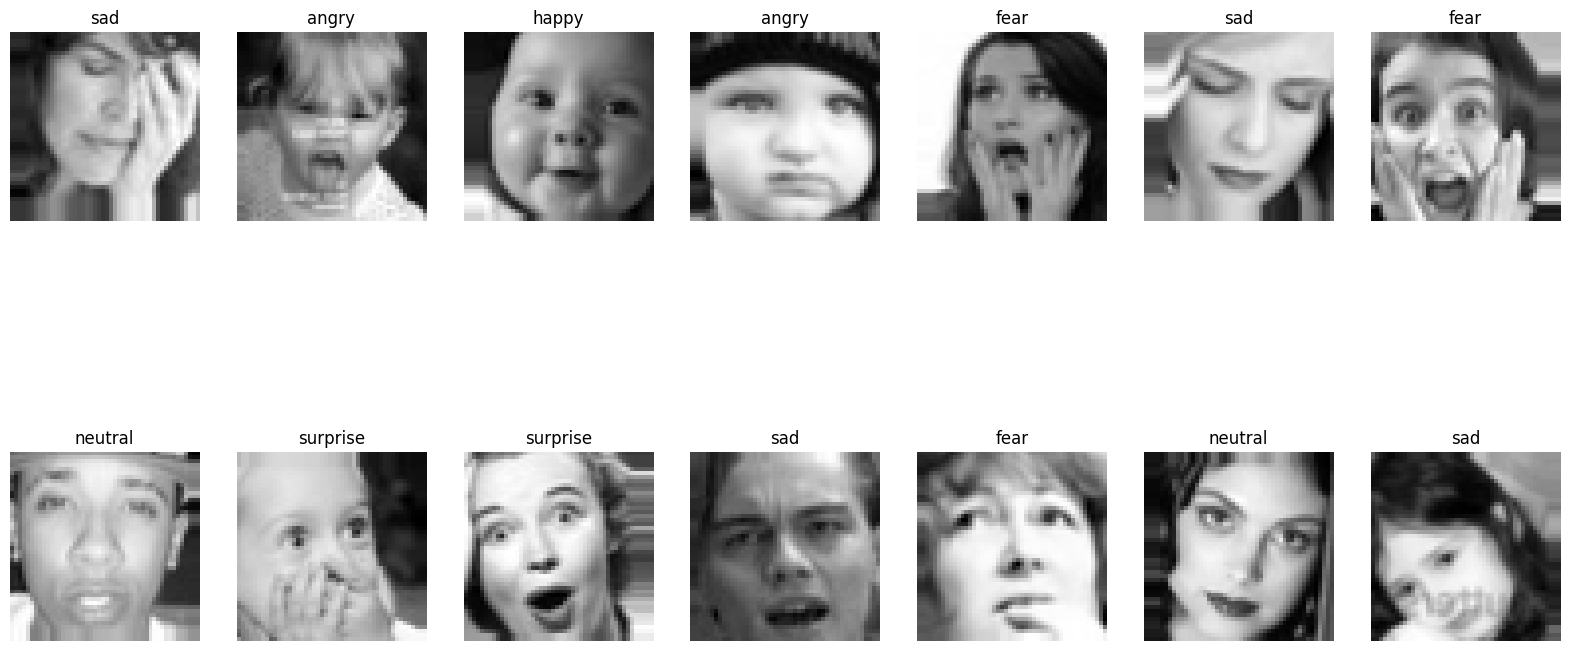

In [10]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np 

r = random.sample(range(X_train.shape[0]), 14)
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(X_train[r[i]],'gray')
    plt.title(class_names_swap[np.argmax(y_train[r[i]])])
    plt.axis("off")    

In [11]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))
# model.fit_generator(..., class_weight=train_class_weights)

In [12]:
train_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

In [13]:
class_names_swap

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [14]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [15]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [16]:
def model_two(shape = (32, 32, 3), classes = 10):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = convolutional_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = convolutional_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = convolutional_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(256, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "model_two")
    return model

In [17]:
model = model_two(shape = (48, 48, 1), classes = 7)

epochs = 60
batch_size = 64
model.summary()

Model: "model_two"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 27, 27, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                               

                                                                                                  
 activation_8 (Activation)      (None, 7, 7, 128)    0           ['add_3[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 7, 7, 128)    0           ['activation_8[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 7, 7, 128)    147584      ['dropout[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 7, 7, 128)   512         ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activatio

                                                                                                  
 conv2d_20 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_17[0][0]']          
                                                                                                  
 batch_normalization_18 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 4, 4, 256)    0           ['batch_normalization_18[0][0]', 
                                                                  'dropout_1[0][0]']              
                                                                                                  
 activation_18 (Activation)     (None, 4, 4, 256)    0           ['add_8[0][0]']                  
          

 batch_normalization_27 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_27[0][0]']          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_13 (A

                                                                  'activation_34[0][0]']          
                                                                                                  
 activation_36 (Activation)     (None, 2, 2, 512)    0           ['add_17[0][0]']                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_36[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 2, 2, 512)    0           ['batch_normalization_37[0][0]'] 
          

In [18]:
model.compile(
    optimizer = 'adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [19]:
import scipy.integrate

import scipy.special
import scipy

history = model.fit(x = train_generator,epochs = 60,batch_size=batch_size,validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/60
359/359 [==============================] - 258s 686ms/step - loss: 2.0501 - accuracy: 0.1555 - val_loss: 1.9958 - val_accuracy: 0.1173
Epoch 2/60
359/359 [==============================] - 82s 228ms/step - loss: 1.9140 - accuracy: 0.1699 - val_loss: 20.1311 - val_accuracy: 0.1676
Epoch 3/60
359/359 [==============================] - 84s 234ms/step - loss: 1.8805 - accuracy: 0.2203 - val_loss: 1.8961 - val_accuracy: 0.1711
Epoch 4/60
359/359 [==============================] - 85s 236ms/step - loss: 1.8321 - accuracy: 0.2490 - val_loss: 2.5922 - val_accuracy: 0.1655
Epoch 5/60
359/359 [==============================] - 85s 237ms/step - loss: 1.8142 - accuracy: 0.2732 - val_loss: 1.8196 - val_accuracy: 0.2332
Epoch 6/60
359/359 [==============================] - 86s 239ms/step - loss: 1.7790 - accuracy: 0.2805 - val_loss: 1.8354 - val_accuracy: 0.3122
Epoch 7/60
359/359 [==============================] - 86s 240ms/step - loss: 1.7478 - accuracy: 0.2877 - val_loss: 1.9414 - val_

359/359 [==============================] - 89s 247ms/step - loss: 1.0217 - accuracy: 0.5782 - val_loss: 1.2385 - val_accuracy: 0.5272
Epoch 58/60
359/359 [==============================] - 89s 248ms/step - loss: 1.0042 - accuracy: 0.5840 - val_loss: 1.2990 - val_accuracy: 0.5370
Epoch 59/60
359/359 [==============================] - 89s 247ms/step - loss: 1.0262 - accuracy: 0.5805 - val_loss: 1.2318 - val_accuracy: 0.5419
Epoch 60/60
359/359 [==============================] - 89s 247ms/step - loss: 0.9934 - accuracy: 0.5877 - val_loss: 1.2251 - val_accuracy: 0.5510


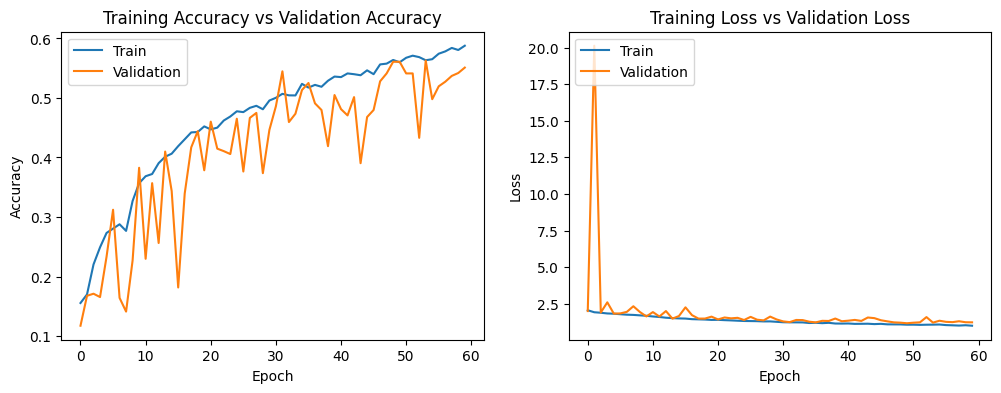

In [20]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [22]:
model.save('dropout32_model.h5')
model.save_weights('dropout32_weights.h5')

In [23]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 1s 62ms/step - loss: 1.2251 - accuracy: 0.5510
final train accuracy = 54.55 , validation accuracy = 55.10


23/23 [==============================] - 2s 72ms/step
Confusion Matrix
[[10 10 12 39 52 43 25]
 [ 1  1  0 11  3  5  1]
 [13  5 19 41 59 41 26]
 [20 24 30 73 93 81 33]
 [12 11 14 55 57 58 39]
 [ 8 11 21 54 64 60 31]
 [11  8 12 30 51 34 20]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.05      0.08       191
     disgust       0.01      0.05      0.02        22
        fear       0.18      0.09      0.12       204
       happy       0.24      0.21      0.22       354
     neutral       0.15      0.23      0.18       246
         sad       0.19      0.24      0.21       249
    surprise       0.11      0.12      0.12       166

    accuracy                           0.17      1432
   macro avg       0.15      0.14      0.14      1432
weighted avg       0.17      0.17      0.16      1432



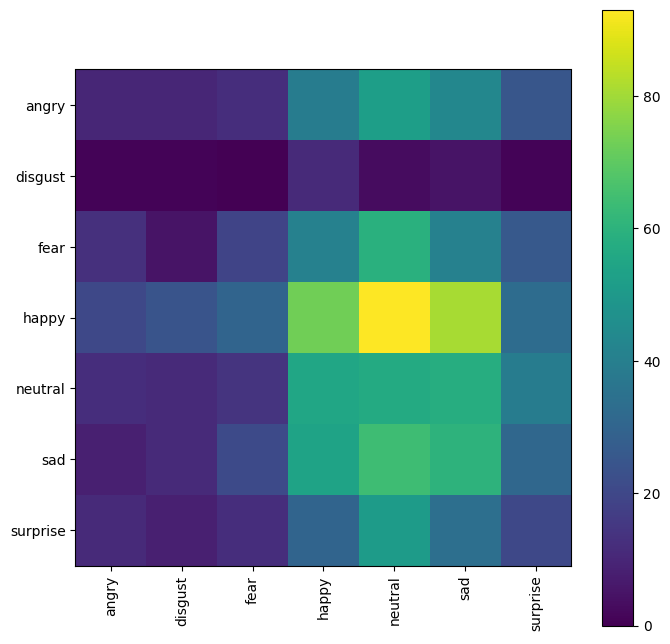

In [24]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

359/359 [==============================] - 21s 60ms/step
Confusion Matrix
[[ 145  117  191  699  875  797  372]
 [  14   10   21   81  100   84   39]
 [ 153  136  203  697  874  810  405]
 [ 287  222  355 1238 1564 1436  670]
 [ 174  175  234  857 1059  975  498]
 [ 180  149  221  851 1043  928  492]
 [  95   85  170  561  663  627  336]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.05      0.07      3196
     disgust       0.01      0.03      0.02       349
        fear       0.15      0.06      0.09      3278
       happy       0.25      0.21      0.23      5772
     neutral       0.17      0.27      0.21      3972
         sad       0.16      0.24      0.19      3864
    surprise       0.12      0.13      0.13      2537

    accuracy                           0.17     22968
   macro avg       0.14      0.14      0.13     22968
weighted avg       0.17      0.17      0.16     22968



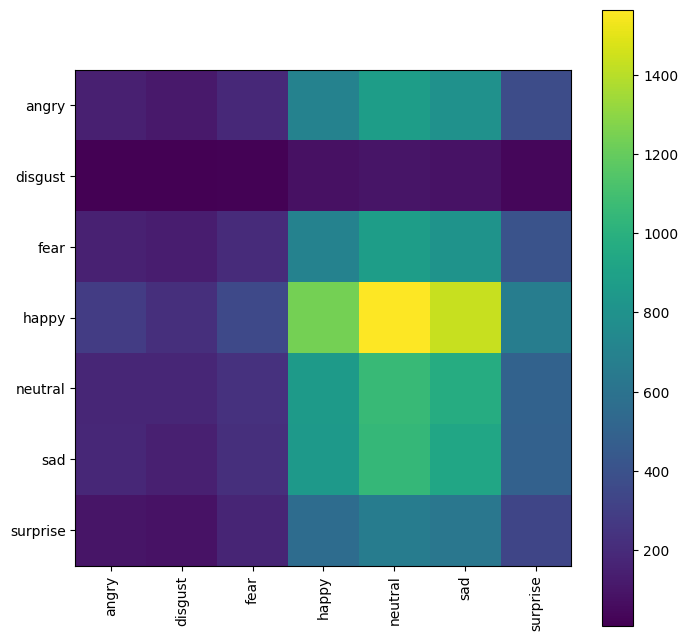

In [25]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)